In [1]:
# PTB-XL Transformer Version 

import os
import pandas as pd
import numpy as np
import ast
import wfdb
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tqdm import tqdm
from scipy.signal import resample

In [2]:
# Paths
ptbxl_path = "/media/nicholas/Storage/Datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv"
scp_path = "/media/nicholas/Storage/Datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv"
waveform_path = "/media/nicholas/Storage/Datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

In [3]:
# Load CSV & SCP mappings
df = pd.read_csv(ptbxl_path)
scp_df = pd.read_csv(scp_path)
df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
df['scp_keys'] = df['scp_codes'].apply(lambda x: list(x.keys()))

target_labels = ['NORM', 'SR', 'AFIB', 'PVC', 'LVH', 'ABQRS', 'IMI', 'ASMI', 'LAFB', 'IRBBB']
df['scp_filtered'] = df['scp_keys'].apply(lambda x: [k for k in x if k in target_labels])
df = df[df['scp_filtered'].map(len) > 0]

mlb = MultiLabelBinarizer(classes=target_labels)
y = mlb.fit_transform(df['scp_filtered'])
print(f"Remaining samples: {len(df)}")

Remaining samples: 20904


In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [5]:
# ECG waveform loader (downsample to 1000 for Transformer)
def load_ecg(record_path, signal_len=5000, downsample_to=1000):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal.T
    if signal.shape[1] < signal_len:
        pad_width = signal_len - signal.shape[1]
        signal = np.pad(signal, ((0,0),(0,pad_width)), 'constant')
    else:
        signal = signal[:, :signal_len]
    signal = resample(signal, downsample_to, axis=1)
    return signal

In [6]:
# PyTorch Dataset
class PTBXL_Dataset(Dataset):
    def __init__(self, df, labels, base_dir, signal_len=5000, downsample_to=1000):
        self.df = df
        self.labels = labels
        self.base_dir = base_dir
        self.signal_len = signal_len
        self.downsample_to = downsample_to

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['filename_lr'])
        signal = load_ecg(full_path, self.signal_len, self.downsample_to)
        signal = signal.T  # (time, features)
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

In [7]:
# DataLoaders
train_dataset = PTBXL_Dataset(X_train, y_train, waveform_path)
test_dataset = PTBXL_Dataset(X_test, y_test, waveform_path)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=4, pin_memory=True)

In [8]:
# Transformer Model
class ECG_Transformer(nn.Module):
    def __init__(self, seq_len=1000, num_features=12, d_model=32, nhead=2, num_layers=2, num_classes=10):
        super(ECG_Transformer, self).__init__()
        self.input_linear = nn.Linear(num_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.input_linear(x)
        x = self.transformer_encoder(x)
        x = x.permute(0, 2, 1)
        x = self.global_avg_pool(x).squeeze(-1)
        x = self.fc(x)
        return x

In [9]:
# Model Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG_Transformer(seq_len=1000, num_features=12, num_classes=len(target_labels)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
losses = []
accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for signals, labels in train_loader_tqdm:
        signals, labels = signals.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        acc = (preds == labels).float().mean().item()
        correct += acc
        total += 1
        train_loader_tqdm.set_postfix(loss=loss.item())
        losses.append(total_loss / len(train_loader))
    accuracies.append(correct / total)
    print(f"Epoch {epoch+1}, Avg Loss: {total_loss/len(train_loader):.4f}, Avg Accuracy: {correct/total:.4f}")
    

Epoch 1/10: 100%|███████████████| 2091/2091 [02:27<00:00, 14.18it/s, loss=0.409]


Epoch 1, Avg Loss: 0.3343, Avg Accuracy: 0.8696


Epoch 2/10: 100%|███████████████| 2091/2091 [00:35<00:00, 59.62it/s, loss=0.279]


Epoch 2, Avg Loss: 0.3080, Avg Accuracy: 0.8790


Epoch 3/10: 100%|███████████████| 2091/2091 [00:36<00:00, 57.66it/s, loss=0.256]


Epoch 3, Avg Loss: 0.2928, Avg Accuracy: 0.8845


Epoch 4/10: 100%|███████████████| 2091/2091 [00:35<00:00, 59.11it/s, loss=0.191]


Epoch 4, Avg Loss: 0.2838, Avg Accuracy: 0.8880


Epoch 5/10: 100%|███████████████| 2091/2091 [00:35<00:00, 59.24it/s, loss=0.158]


Epoch 5, Avg Loss: 0.2793, Avg Accuracy: 0.8894


Epoch 6/10: 100%|███████████████| 2091/2091 [00:35<00:00, 59.36it/s, loss=0.324]


Epoch 6, Avg Loss: 0.2744, Avg Accuracy: 0.8914


Epoch 7/10: 100%|███████████████| 2091/2091 [00:35<00:00, 59.24it/s, loss=0.253]


Epoch 7, Avg Loss: 0.2695, Avg Accuracy: 0.8926


Epoch 8/10: 100%|███████████████| 2091/2091 [00:35<00:00, 59.08it/s, loss=0.489]


Epoch 8, Avg Loss: 0.2638, Avg Accuracy: 0.8938


Epoch 9/10: 100%|███████████████| 2091/2091 [00:35<00:00, 58.96it/s, loss=0.236]


Epoch 9, Avg Loss: 0.2591, Avg Accuracy: 0.8955


Epoch 10/10: 100%|██████████████| 2091/2091 [00:35<00:00, 58.99it/s, loss=0.464]

Epoch 10, Avg Loss: 0.2555, Avg Accuracy: 0.8967


In [10]:
# Evaluation

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for signals, labels in test_loader:
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        y_true.append(labels.cpu().numpy())
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

print("Classification Report:")
print(classification_report(y_true > 0.5, y_pred > 0.5, target_names=mlb.classes_))
print("Macro ROC-AUC:", roc_auc_score(y_true, y_pred, average='macro'))

Classification Report:
              precision    recall  f1-score   support

        NORM       0.81      0.81      0.81      1918
          SR       0.82      0.99      0.90      3394
        AFIB       0.51      0.06      0.11       294
         PVC       0.81      0.45      0.58       214
         LVH       0.75      0.28      0.41       412
       ABQRS       0.58      0.32      0.41       634
         IMI       0.56      0.31      0.40       512
        ASMI       0.53      0.46      0.50       474
        LAFB       0.73      0.55      0.63       327
       IRBBB       1.00      0.03      0.07       238

   micro avg       0.77      0.70      0.74      8417
   macro avg       0.71      0.43      0.48      8417
weighted avg       0.75      0.70      0.69      8417
 samples avg       0.78      0.73      0.73      8417

Macro ROC-AUC: 0.8629053372084752


/home/nicholas/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


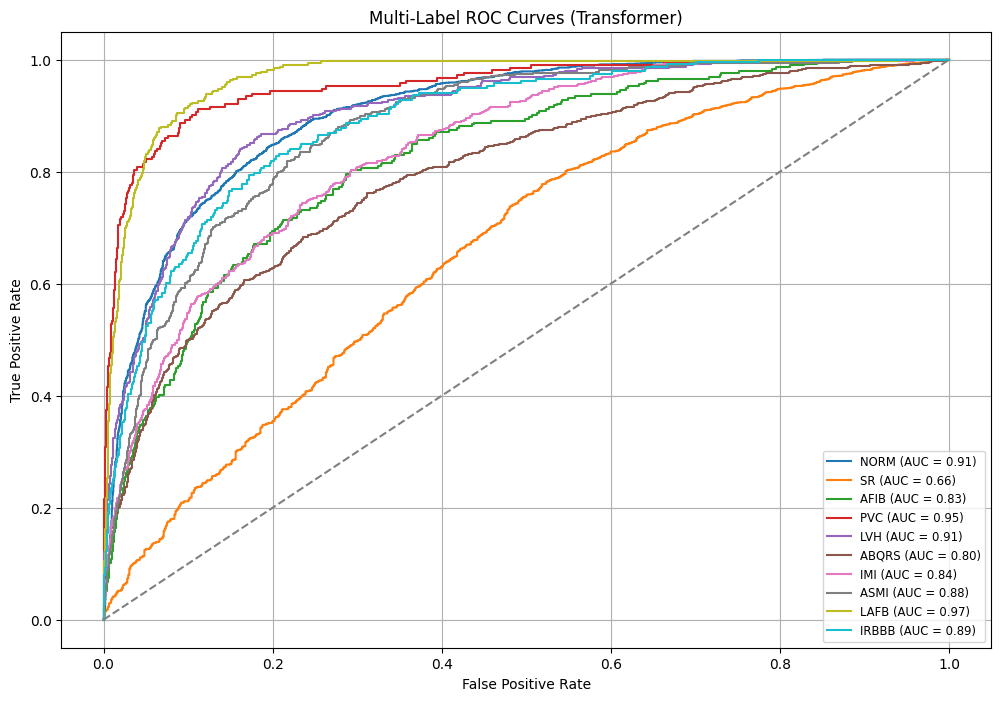

In [11]:
# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i, label in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Label ROC Curves (Transformer)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.show()